#  Image Processing - SCC5830

## Assignment 02 - Image Enhancement and Filtering

### Author: Victor Hugo Sillerico Justo

In [1]:
## ================================================
# Name:        Victor Hugo Sillerico Justo
# No. USP:     11904461
# Course Code: SCC5830 (Image Processing)
# Year:        2020
# Semester:    I
# Assigment 2: Image Enhancement and Filtering
## ================================================

In [2]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import math

# ********** AUXILIAR FUNCTIONS TO ADD & REMOVE PADDING **********
# Function to Add Padding to the INPUT image
def addPadding(input_img,N,M,n):
    indI =  int((n-1)/2) # auxiliar variable to get the extra rows & columns to add
    imgp = np.zeros((N+(2*indI),M+(2*indI))) 
    for i in range(indI,N+indI):
        for j in range(indI,M+indI):
            imgp[i,j] = input_img[i-indI,j-indI] # copy the original image inside the expanded image
    return imgp

# Function to Remove Padding from the OUTPUT image
def removePadding(input_img,N,M,n):
    indI =  int((n-1)/2) # auxiliar variable to get the extra rows & columns to remove
    imgwp = np.zeros((N,M))
    for i in range(indI,N+indI):
        for j in range(indI,M+indI):
            imgwp[i-indI,j-indI] = input_img[i,j] # recover the original image from the expanded image
    return imgwp

# ********** FUNCTIONS TO APPLY BILATERAL FILTERING **********
# auxiliar function to calulate the Euclidean distance between the position of the intensity
# and the center (0,0)
def Edist(n):
    aux = int((n-1)/2) # auxiliar variable to center the filter at the origin
    E = np.zeros((n,n))
    for i in range(0, n):
        for j in range(0, n):    
            x = i-aux
            y = j-aux
            E[i,j] = math.sqrt((x**2)+(y**2))
    return E

# auxiliar function to calculate differences on intensities for each neighborhood
def difIntensity(I,n):
    difI = np.zeros((n,n))
    c = int((n-1)/2)  
    Ixy = I[c,c]  # pixel in the center
    Ixy = np.full((n,n), I[c,c])
    difI = np.subtract(I,Ixy) # to get:  "I - I(x,y)"
    return difI 

# auxiliar function to calculate the NEW value of intensity for a pixel
def newIntensity_i(I,n,sig_r,gs):
    Xgri = difIntensity(I,n)
    gr = (1/(2*np.pi*sig_r**2))*np.exp(-(Xgri**2)/(2*sig_r**2)) # get the RANGE GAUSSIAN component
    w = np.multiply(gr,gs) # get the total value of the filter
    Wp = np.sum(w) # get the normalization factor Wp
    Ifi = np.multiply(w,I)
    If = np.sum(Ifi) # total value of the NEW intensity 
    Ifp = If/Wp # apply the normalization
    return Ifp

# MAIN function to calculate the modified the image using the BILATERAL FILTER
def BilateralFilter(img, n, sig_r, gs):
    # add padding to apply the filter to ALL pixels
    Nprev,Mprev = img.shape
    input_img = addPadding(img,Nprev,Mprev,n)
    # iniciate the NEW filtered image
    imgFiltered = np.zeros(input_img.shape)
    N,M = input_img.shape
    a = int((n-1)/2) # auxiliar variable to center the filter at the origin
    for x in range(a, N-a):
        for y in range(a, M-a):
            region_img = input_img[ x-a : x+(a+1), y-a : y+(a+1)] # get the region in which the filtered will be applied
            imgFiltered[x,y] = newIntensity_i(region_img,n,sig_r,gs) # store the NEW intensity value
    imgFinal = removePadding(imgFiltered,Nprev,Mprev,n) # remove the padding from the filtered image      
    return imgFinal

# ********** FUNCTIONS TO APPLY UNSHARP MARK USING LAPLACIAN FILTER **********
# Function to apply Unsharp Mask using the Laplacian Filter
def unsharpMaskLF(img,c,k):
    Nprev,Mprev = img.shape
    input_img = addPadding(img,Nprev,Mprev,3) # add padding to apply the filter to ALL pixels 
    imgMod = np.zeros(input_img.shape)
    N,M = input_img.shape
    # select the kind of KERNEL
    if(k == 1):
        kernel = np.matrix([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    if(k == 2):
        kernel = np.matrix([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
    # apply the filter for each pixel using its corresponding neighborhood
    for x in range(1, N-1):
        for y in range(1, M-1):
            region_img = input_img[ x-1 : x+(1+1), y-1 : y+(1+1)] 
            newRegVal = np.multiply(region_img,kernel) # apply the kernel
            newIntensityVal = np.sum(newRegVal)
            imgMod[x,y] = newIntensityVal # new filtered image
    
    imgFiltered = removePadding(imgMod,N-2,M-2,3) # recover the original image
    # scaling the filtered image
    minImg = np.min(imgFiltered)
    maxImg = np.max(imgFiltered)
    imgScaled = (imgFiltered-minImg)*255/(maxImg-minImg)
    # adding the filtered-scaled image to the original image
    imgFinal = (c*imgScaled)+img
    # scaling the final image
    minImgFinal = np.min(imgFinal)
    maxImgFinal = np.max(imgFinal)
    imgFinalScaled = (imgFinal-minImgFinal)*255/(maxImgFinal-minImgFinal)
    return imgFinalScaled


# ********** FUNCTIONS TO APPLY VIGNETTE FILTER **********
# Function to apply Vignette Filter
def vignetteFilter(img, sig_row, sig_col):
    R,C = img.shape
    # define the auxiliar matrix to get the 1D Gaussian Kernel
    Wrow = np.zeros((1,R))
    Wcol = np.zeros((1,C))
    # auxiliar variable to center the kernel at the origin    
    nR = int((R-1)/2)
    nC = int((C-1)/2)
    # get the 1D Gaussian Kernel associated to the ROWs
    for i in range(0,R):
        x = i - nR
        # calculate the 1D Gaussian
        Wrow[0,i] = (1/(2*np.pi*sig_row**2))*np.exp(-(x**2)/(2*sig_row**2))
    # get the 1D Gaussian Kernel associated to the COLUMNs
    for i in range(0,C):
        x = i - nC
        # calculate the 1D Gaussian
        Wcol[0,i] = (1/(2*np.pi*sig_col**2))*np.exp(-(x**2)/(2*sig_col**2))
    # get the total KERNEL
    W = np.multiply(Wrow.transpose(),Wcol)
    # apply the filter
    imgFiltered = np.multiply(img,W)
    # Scaling the filtered image
    minImg = np.min(imgFiltered)
    maxImg = np.max(imgFiltered)
    imgScaled = (imgFiltered-minImg)*255/(maxImg-minImg)
    return imgScaled

# Function to calculate the Root Square Error (RSE)   
def RSE(r_img,m_img):
    s=0
    r,c = r_img.shape
    # Comparing each pixel to get the error
    for i in np.arange(r):
        for j in np.arange(c):
            s = s+(m_img[i,j]-r_img[i,j])**2
    return np.sqrt(s)

## Example 1 - Method 1 (Bilateral Filter)

Error for the Test Case 1 (run.codes):  3426.2696


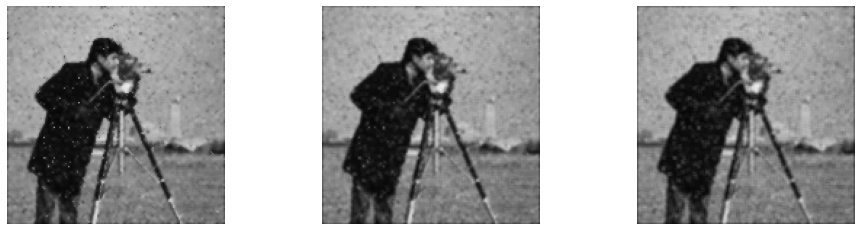

In [3]:
input_img1 = imageio.imread("images/camera.png")
n = 3

# Test Case 1 provided in run.codes
sig_s = 150.0
sig_r = 100.0
input_img1 = input_img1.astype(np.float)
X = Edist(n)
gs = (1/(2*np.pi*sig_s**2))*np.exp(-(X**2)/(2*sig_s**2))
output_img11 = BilateralFilter(input_img1, n, sig_r, gs)

# Aditional case 1
sig_s = 100.0
sig_r = 150.0
output_img12 = BilateralFilter(input_img1, n, sig_r, gs)

# Aditional case 2
sig_s = 100.0
sig_r = 240.0
output_img13 = BilateralFilter(input_img1, n, sig_r, gs)

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(output_img11, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(132)
plt.imshow(output_img12, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(133)
plt.imshow(output_img13, cmap="gray", vmin=0, vmax=255)
plt.axis('off')

# Getting the Root Square Error (RSE) with 4 decimals
val_rse = RSE(input_img1,output_img11)
val_rse = np.around(val_rse,decimals=4)
print("Error for the Test Case 1 (run.codes): ",val_rse)

## Example 2 - Method 1 (Bilateral Filter)

Error for the Test Case 2 (run.codes):  1782.5694


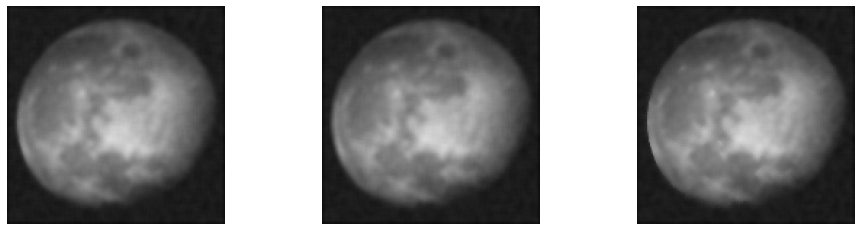

In [4]:
input_img1 = imageio.imread("images/moon.png")
n = 5

# Test Case 2 provided in run.codes
sig_s = 50.0
sig_r = 100.0
input_img1 = input_img1.astype(np.float)
X = Edist(n)
gs = (1/(2*np.pi*sig_s**2))*np.exp(-(X**2)/(2*sig_s**2))
output_img11 = BilateralFilter(input_img1, n, sig_r, gs)

# Aditional case 1
sig_s = 100.0
sig_r = 200.0
output_img12 = BilateralFilter(input_img1, n, sig_r, gs)

# Aditional case 2
sig_s = 10.0
sig_r = 50.0
output_img13 = BilateralFilter(input_img1, n, sig_r, gs)

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(output_img11, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(132)
plt.imshow(output_img12, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(133)
plt.imshow(output_img13, cmap="gray", vmin=0, vmax=255)
plt.axis('off')

# Getting the Root Square Error (RSE) with 4 decimals
val_rse = RSE(input_img1,output_img11)
val_rse = np.around(val_rse,decimals=4)
print("Error for the Test Case 2 (run.codes): ",val_rse)

## Example 3 - Method 2 (Unsharp mask using the Laplacian Filter)

Error for the Test Case 3 (run.codes):  2519.4489


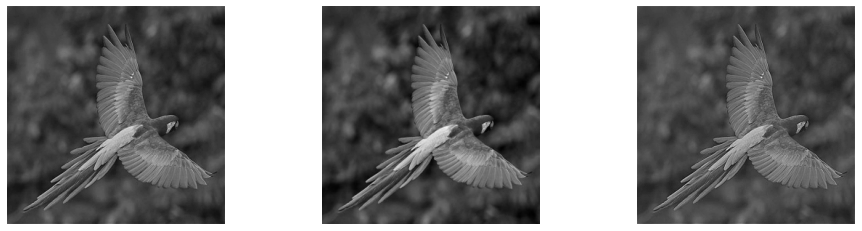

In [5]:
input_img1 = imageio.imread("images/arara.png")
input_img1 = input_img1.astype(np.float)

# Test Case 3 provided in run.codes
c = 0.5
k = 1
output_img11 = unsharpMaskLF(input_img1, c, k)

# Aditional case 1
c = 0.1
k = 1
output_img12 = unsharpMaskLF(input_img1, c, k)

# Aditional case 2
c = 0.9
k = 1
output_img13 = unsharpMaskLF(input_img1, c, k)

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(output_img11, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(132)
plt.imshow(output_img12, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(133)
plt.imshow(output_img13, cmap="gray", vmin=0, vmax=255)
plt.axis('off')

# Getting the Root Square Error (RSE) with 4 decimals
val_rse = RSE(input_img1,output_img11)
val_rse = np.around(val_rse,decimals=4)
print("Error for the Test Case 3 (run.codes): ",val_rse)

## Example 4 - Method 2 (Unsharp mask using the Laplacian Filter)

Error for the Test Case 4 (run.codes):  3664.368


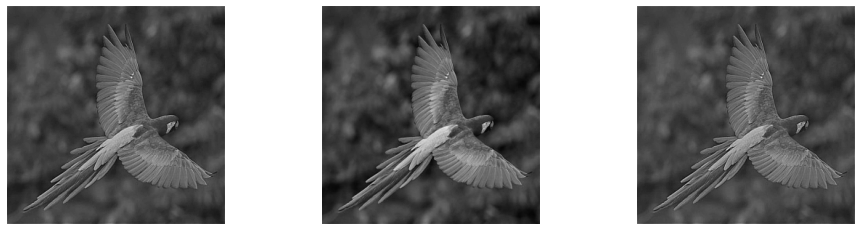

In [6]:
input_img1 = imageio.imread("images/arara.png")
input_img1 = input_img1.astype(np.float)

# Test Case 4 provided in run.codes
c = 0.75
k = 2
output_img11 = unsharpMaskLF(input_img1, c, k)

# Aditional case 1
c = 0.25
k = 2
output_img12 = unsharpMaskLF(input_img1, c, k)

# Aditional case 2
c = 0.97
k = 2
output_img13 = unsharpMaskLF(input_img1, c, k)

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(output_img11, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(132)
plt.imshow(output_img12, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(133)
plt.imshow(output_img13, cmap="gray", vmin=0, vmax=255)
plt.axis('off')

# Getting the Root Square Error (RSE) with 4 decimals
val_rse = RSE(input_img1,output_img11)
val_rse = np.around(val_rse,decimals=4)
print("Error for the Test Case 4 (run.codes): ",val_rse)

## Example 5 - Method 3 (Vignette Filter)

Error for the Test Case 5 (run.codes):  16972.4239


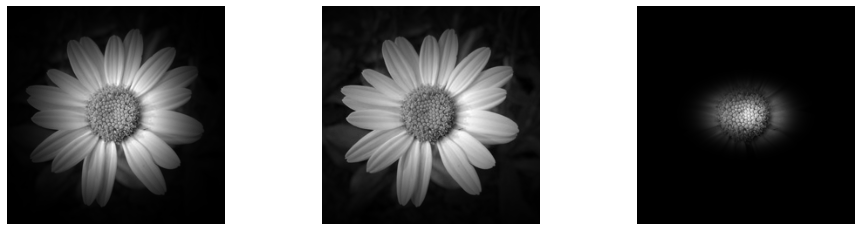

In [8]:
input_img1 = imageio.imread("images/flower.png")
input_img1 = input_img1.astype(np.float)

# Test Case 5 provided in run.codes
sig_row = 50.0
sig_col = 50.0
output_img11 = vignetteFilter(input_img1, sig_row, sig_col)

# Aditional case 1
sig_row = 60.0
sig_col = 90.0
output_img12 = vignetteFilter(input_img1, sig_row, sig_col)

# Aditional case 2
sig_row = 15.0
sig_col = 23.0
output_img13 = vignetteFilter(input_img1, sig_row, sig_col)

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(output_img11, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(132)
plt.imshow(output_img12, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(133)
plt.imshow(output_img13, cmap="gray", vmin=0, vmax=255)
plt.axis('off')

# Getting the Root Square Error (RSE) with 4 decimals
val_rse = RSE(input_img1,output_img11)
val_rse = np.around(val_rse,decimals=4)
print("Error for the Test Case 5 (run.codes): ",val_rse)

## Example 6 - Method 3 (Vignette Filter)

Error for the Test Case 6 (run.codes):  20391.1069


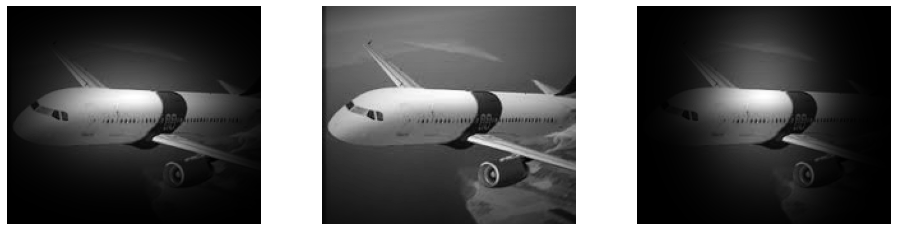

In [9]:
input_img1 = imageio.imread("images/airplane.png")
input_img1 = input_img1.astype(np.float)

# Test Case 6 provided in run.codes
sig_row = 30.0
sig_col = 45.0
output_img11 = vignetteFilter(input_img1, sig_row, sig_col)

# Aditional case 1
sig_row = 70.0
sig_col = 100.0
output_img12 = vignetteFilter(input_img1, sig_row, sig_col)

# Aditional case 2
sig_row = 40.0
sig_col = 30.0
output_img13 = vignetteFilter(input_img1, sig_row, sig_col)

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(output_img11, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(132)
plt.imshow(output_img12, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(133)
plt.imshow(output_img13, cmap="gray", vmin=0, vmax=255)
plt.axis('off')

# Getting the Root Square Error (RSE) with 4 decimals
val_rse = RSE(input_img1,output_img11)
val_rse = np.around(val_rse,decimals=4)
print("Error for the Test Case 6 (run.codes): ",val_rse)